In [9]:
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statistics import mode
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, GRU, SimpleRNN, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hyperparameter
import ray
from ray import train, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.air.integrations.keras import ReportCheckpointCallback

from tensorflow.keras.optimizers import Adam, RMSprop
from functools import partial
from ray.tune.schedulers import ASHAScheduler


# Setting the random seeds for reproductibility
np.random.seed(42)
random.seed(42)

# Read Data Files

In [10]:

# File paths
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
file_path_healthy5 = './HIL Data 062024/ACC faults different scenarios/Sc5Healthy.csv'
file_path_delay5 = './HIL Data 062024/ACC faults different scenarios/Sc5DelayAPP.csv'
file_path_gain5 = './HIL Data 062024/ACC faults different scenarios/SC5GainAPP.csv'
file_path_noise5 = './HIL Data 062024/ACC faults different scenarios/Sc5NoiseAPP.csv'
file_path_loss5 = './HIL Data 062024/ACC faults different scenarios/Sc5PacketLossAPP.csv'

file_path_healthy4 = './HIL Data 062024/ACC faults different scenarios/Sc4Healthy.csv'
file_path_delay4 = './HIL Data 062024/ACC faults different scenarios/Sc4DelayApp.csv'
file_path_gain4 = './HIL Data 062024/ACC faults different scenarios/Sc4GainAPP.csv'
file_path_noise4 = './HIL Data 062024/ACC faults different scenarios/Sc4NoiseAPP.csv'
file_path_loss4 = './HIL Data 062024/ACC faults different scenarios/SC4PacketLossAPP.csv'

file_path_healthy3 = './HIL Data 062024/ACC faults different scenarios/Sc3_Healthy.csv'
file_path_delay3 = './HIL Data 062024/ACC faults different scenarios/Sc3DelayAPP.csv'
file_path_gain3 = './HIL Data 062024/ACC faults different scenarios/Sc3GainAPP.csv'
file_path_noise3 = './HIL Data 062024/ACC faults different scenarios/Sc3_Noise_APP_50.csv'
file_path_loss3 = './HIL Data 062024/ACC faults different scenarios/Sc3PacketlossAPP.csv'

file_path_healthy2 = './HIL Data 062024/ACC faults different scenarios/SC2_healthy.csv'
file_path_delay2 = './HIL Data 062024/ACC faults different scenarios/Sc2_APP_Delay.csv'
file_path_gain2 = './HIL Data 062024/ACC faults different scenarios/gainAPP_High_50.csv'
file_path_noise2 = './HIL Data 062024/ACC faults different scenarios/Sc2_Noise-APP.csv'
file_path_loss2 = './HIL Data 062024/ACC faults different scenarios/PacketLossAPP.csv'


# Function to parse the general information section


def parse_general_info(lines):
    general_info = {}
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 3:
            category, key, value = parts[0], parts[1], parts[2]
            if category == "General":
                general_info[key] = value
    return general_info

# Function to parse the trace information section


def parse_trace_info(lines):
    trace_info = {}
    headers = lines[0].split('\t')
    for line in lines[1:]:
        values = line.split('\t')
        for i, header in enumerate(headers):
            if i < len(values):
                if header not in trace_info:
                    trace_info[header] = []
                trace_info[header].append(values[i])
    return trace_info

# Function to parse the trace values section


def parse_trace_values(lines):
    trace_values = [line.split(',') for line in lines]
    df = pd.DataFrame(trace_values[1:], columns=trace_values[0])
    return df

# Read the text data


def read_this(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse sections
    general_info_lines = []
    trace_info_lines = []
    trace_values_lines = []
    current_section = None

    for line in lines:
        line = line.strip()
        if 'descriptions' in line:
            current_section = 'general_info'
        elif 'trace_size' in line:
            current_section = 'trace_info'
        elif 'trace_values' in line:
            current_section = 'trace_values'
        elif line:
            if current_section == 'general_info':
                general_info_lines.append(line)
            elif current_section == 'trace_info':
                trace_info_lines.append(line)
            elif current_section == 'trace_values':
                trace_values_lines.append(line)

    # Process sections
    general_info = parse_general_info(general_info_lines)
    trace_info = parse_trace_info(trace_info_lines)
    trace_values = parse_trace_values(trace_values_lines).values.flatten()

    cleaned_trace_values = []

    for x in trace_values:
        try:
            cleaned_trace_values.append(float(x))
        except ValueError:
            cleaned_trace_values.append(np.nan)

    return general_info, trace_info, np.array(cleaned_trace_values)

# Function to pad data to the reference length


def pad_data(data, ref_length):
    padded_data = np.pad(
        data, (0, max(0, ref_length - len(data))), 'constant', constant_values=np.nan)
    return padded_data[:ref_length]

In [11]:
# Initialize dictionaries to store the data
healthy_data = pd.DataFrame()
delay_data = pd.DataFrame()
gain_data = pd.DataFrame()
noise_data = pd.DataFrame()
loss_data = pd.DataFrame()

# Function to extract trace values and store in the dictionary


def store_trace_values(data_dict, file_path, scenario, ref_length=None):
    values = read_this(file_path)[2]
    if ref_length is not None:
        values = pad_data(values, ref_length)
    data_dict[scenario] = values


# Read data and store trace values in the corresponding dictionaries
# Store the first dataset length as the reference length
ref_length = len(read_this(file_path_healthy5)[2])

store_trace_values(healthy_data, file_path_healthy5, "SC5", ref_length)
store_trace_values(healthy_data, file_path_healthy4, "SC4", ref_length)
store_trace_values(healthy_data, file_path_healthy3, "SC3", ref_length)
store_trace_values(healthy_data, file_path_healthy2, "SC2", ref_length)

store_trace_values(delay_data, file_path_delay5, "SC5", ref_length)
store_trace_values(delay_data, file_path_delay4, "SC4", ref_length)
store_trace_values(delay_data, file_path_delay3, "SC3", ref_length)
store_trace_values(delay_data, file_path_delay2, "SC2", ref_length)

store_trace_values(gain_data, file_path_gain5, "SC5", ref_length)
store_trace_values(gain_data, file_path_gain4, "SC4", ref_length)
store_trace_values(gain_data, file_path_gain3, "SC3", ref_length)
store_trace_values(gain_data, file_path_gain2, "SC2", ref_length)

store_trace_values(noise_data, file_path_noise5, "SC5", ref_length)
store_trace_values(noise_data, file_path_noise4, "SC4", ref_length)
store_trace_values(noise_data, file_path_noise3, "SC3", ref_length)
store_trace_values(noise_data, file_path_noise2, "SC2", ref_length)

store_trace_values(loss_data, file_path_loss5, "SC5", ref_length)
store_trace_values(loss_data, file_path_loss4, "SC4", ref_length)
store_trace_values(loss_data, file_path_loss3, "SC3", ref_length)
store_trace_values(loss_data, file_path_loss2, "SC2", ref_length)

# Now you can access the data like this:
# healthy_data["Sc5"], healthy_data["Sc4"], etc.
# delay_data["Sc5"], delay_data["Sc4"], etc.
# gain_data["Sc5"], gain_data["Sc4"], etc.
# noise_data["Sc5"], noise_data["Sc4"], etc.
# loss_data["Sc5"], loss_data["Sc4"], etc.
print(gain_data)

                SC5           SC4           SC3           SC2
0               NaN           NaN           NaN           NaN
1          0.100001      0.100002      0.100001      0.100001
2          1.163056      1.176741    100.000000      1.198839
3        853.553414    731.114940    731.321758    752.060314
4          2.048061      0.282540      1.228602      8.747663
...             ...           ...           ...           ...
72040     45.391295     57.678575     46.201784     64.701434
72041   2519.120570   2402.974688   2273.657397   2346.741715
72042  38472.977711  41418.314394  73656.637490  74977.188910
72043    120.287782    119.926512    109.359398    111.572773
72044    114.205840     90.903495     40.530456      1.832876

[72045 rows x 4 columns]


In [12]:
# Align the DataFrames to ensure they have the same columns
healthy_data, gain_data = healthy_data.align(gain_data, join='inner', axis=1)
healthy_data, delay_data = healthy_data.align(delay_data, join='inner', axis=1)
healthy_data, loss_data = healthy_data.align(loss_data, join='inner', axis=1)
healthy_data, noise_data = healthy_data.align(noise_data, join='inner', axis=1)

# Calculate the differences
diff_gain = (healthy_data - gain_data).abs()
diff_delay = (healthy_data - delay_data).abs()
diff_loss = (healthy_data - loss_data).abs()
diff_noise = (healthy_data - noise_data).abs()

# Calculate the labels
label_gain = (diff_gain > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')
label_delay = (diff_delay > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')
label_loss = (diff_loss > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')
label_noise = (diff_noise > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')

print(label_gain)
print(label_delay)
print(label_loss)
print(label_noise)

0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    1
72043    0
72044    0
Length: 72045, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    0
72043    0
72044    0
Length: 72045, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    1
72043    0
72044    0
Length: 72045, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    0
72043    0
72044    0
Length: 72045, dtype: int64


In [13]:
print(healthy_data.shape)
print(delay_data.shape)
print(gain_data.shape)
print(noise_data.shape)

(72045, 4)
(72045, 4)
(72045, 4)
(72045, 4)


In [14]:
# Add label columns to healthy data
healthy_data['delay_class'] = 0
healthy_data['gain_class'] = 0
healthy_data['noise_class'] = 0
healthy_data['loss_class'] = 0

# Add label columns to delay data
delay_data['delay_class'] = label_delay
delay_data['gain_class'] = 0
delay_data['noise_class'] = 0
delay_data['loss_class'] = 0

# Add label columns to gain data
gain_data['gain_class'] = label_gain
gain_data['delay_class'] = 0
gain_data['noise_class'] = 0
gain_data['loss_class'] = 0

# Add label columns to noise data
noise_data['noise_class'] = label_noise
noise_data['delay_class'] = 0
noise_data['gain_class'] = 0
noise_data['loss_class'] = 0

# Add label columns to loss data
loss_data['loss_class'] = label_loss
loss_data['delay_class'] = 0
loss_data['gain_class'] = 0
loss_data['noise_class'] = 0

# Display the DataFrames to verify
print("Healthy Data:")
# drop first row
healthy_data = healthy_data.iloc[1:]
print(healthy_data.head())

print("\nDelay Data:")
delay_data = delay_data.iloc[1:]
print(delay_data.head())

print("\nGain Data:")
gain_data = gain_data.iloc[1:]
print(gain_data.head())

print("\nNoise Data:")
noise_data = noise_data.iloc[1:]
print(noise_data.head())

print("\nLoss Data:")
loss_data = loss_data.iloc[1:]
print(loss_data.head())

Healthy Data:
          SC5         SC4         SC3         SC2  delay_class  gain_class  \
1    0.115201    0.100001    0.100001    0.100001            0           0   
2    1.517328  100.000000    1.480923    1.869330            0           0   
3  731.739848  749.100068  744.772021  724.777170            0           0   
4    2.756631    0.249866   -0.374232   -4.892972            0           0   
5  708.504999  807.318027  751.330866  797.558003            0           0   

   noise_class  loss_class  
1            0           0  
2            0           0  
3            0           0  
4            0           0  
5            0           0  

Delay Data:
          SC5         SC4         SC3         SC2  delay_class  gain_class  \
1    0.100002    0.100002    0.100004    0.100001            0           0   
2    1.063721    1.507832  100.000000    1.634196            0           0   
3  760.028930  740.059567  925.691036  756.030118            0           0   
4    4.812194    2

In [15]:
# Align columns before combining
combined_data = [healthy_data, delay_data, gain_data, noise_data, loss_data]


## Utility Functions

#### Turn the Time Series Data to Sequences

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from statistics import mode

# Combine DataFrames
combined_data = pd.concat(
    [healthy_data, delay_data, gain_data, noise_data, loss_data], ignore_index=True)


def build_model(input_shape, num_classes, units=120, learning_rate=0.0001, dropout=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    print("Model compiled!")
    model.summary()
    return model


def sliding_sequences(df, class_col, test_size=0.2, window_size=50):
    X = []
    y = []

    columns = df.columns.tolist()
    features = [col for col in columns if col != class_col]

    if not features:
        print("No features found. Check your column names.")
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

    X_data = df[features]

    # Normalization
    min_vals = X_data.min()
    max_vals = X_data.max()
    ranges = max_vals - min_vals
    ranges[ranges == 0] = 1  # Prevent division by zero
    scaled_X_data = (X_data - min_vals) / ranges
    df[features] = scaled_X_data

    for i in range(len(df) - window_size + 1):
        temp = df.iloc[i: i + window_size]
        sequence_label = mode(temp[class_col])
        sequence_features = temp[features]
        X.append(sequence_features.values)
        y.append(sequence_label)

    X = np.array(X)
    y_cat = to_categorical(y)
    y_cat = np.array(y_cat)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=test_size, shuffle=True, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


# Example usage
delayX_train, delayX_val, delayX_test, delayY_train, delayY_val, delayY_test = sliding_sequences(
    combined_data, 'delay_class', window_size=50)

# Print shapes
print(f'delayX_train shape: {delayX_train.shape}')
print(f'delayY_train shape: {delayY_train.shape}')
print(f'delayX_val shape: {delayX_val.shape}')
print(f'delayY_val shape: {delayY_val.shape}')

# Build and train the model
input_shape = (delayX_train.shape[1], delayX_train.shape[2])
num_classes = delayY_train.shape[1]

delay_GRUmodel = build_model(
    input_shape, num_classes, units=120, learning_rate=0.0001, dropout=0.2)
delay_history = delay_GRUmodel.fit(
    delayX_train, delayY_train, batch_size=20, epochs=25, validation_data=(delayX_val, delayY_val))

delayX_train shape: (288136, 50, 7)
delayY_train shape: (288136, 1)
delayX_val shape: (36018, 50, 7)
delayY_val shape: (36018, 1)
Model compiled!


/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 120)            │        46,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,041 (183.75 KB)

 Trainable params: 46,801 (182.82 KB)

 Non-trainable params: 240 (960.00 B)

Epoch 1/25


/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


14407/14407 ━━━━━━━━━━━━━━━━━━━━ 282s 20ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 291s 20ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 277s 19ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 260s 18ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 266s 18ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 266s 18ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 274s 19ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/25
14407/14407 ━━━━━━━━━━━━━━━━━━━━ 276s 19m

#### Function to Performing Voting

In [17]:
def single_fault_voter(y_true, predictions):
    threshold = 0.5
    pred = predictions.copy()
    preds = []
    for i in range(len(pred)):
        if max(pred[i]) == pred[i][0]:
            pred[i][0] = 1
            pred[i][1] = 0
            preds.append(1)
        elif max(pred[i] == pred[i][1]):
            pred[i][0] = 0
            pred[i][1] = 1
            preds.append(0)

    actual = []

    for i in range(len(y_true)):
        if max(y_true[i]) == y_true[i][0]:
            y_true[i][0] = 1
            y_true[i][1] = 0
            actual.append(1)
        elif max(pred[i] == pred[i][1]):
            pred[i][0] = 0
            pred[i][1] = 1
            actual.append(0)



    preds = np.array(preds)
    y_true = np.array(actual)
    return y_true, preds

#### Function to Plot the Confusion Matrix

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


def generate_classificationReport(y_test, y_pred):
    report = classification_report(y_test, y_pred, zero_division=1)
    return report


#### Function to plot the history

In [19]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


#### Functions to Train the Model and Perform Hyperparameter Tuning

#### Data Preparation (Normlization, make sequences, one-hot encoding)

##### Gain RPM

In [20]:
gainX_train, gainX_val, gainX_test, gainY_train, gainY_val, gainY_test = sliding_sequences(combined_data,'gain_class',window_size=100)

##### Noise APP

In [21]:
noiseX_train, noiseX_val, noiseX_test, noiseY_train, noiseY_val, noiseY_test = sliding_sequences(combined_data,'noise_class',window_size=100)

##### PacketLoss APP

In [22]:
packetLossX_train, packetLossX_val, packetLossX_test, packetLossY_train, packetLossY_val, packetLossY_test = sliding_sequences(combined_data,'loss_class',window_size=100)

# Training

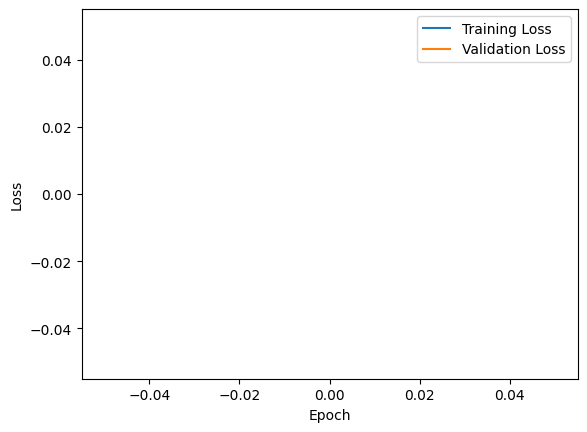

In [23]:
plot_history(delay_history)

In [24]:
joblib.dump(delay_GRUmodel, './delayGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./delayGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

### Gain

In [25]:
gain_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
gain_history = gain_GRUmodel.fit(gainX_train, gainY_train,batch_size=20, epochs=25, validation_data=(gainX_val, gainY_val))


TypeError: build_model() got an unexpected keyword argument 'momentum'

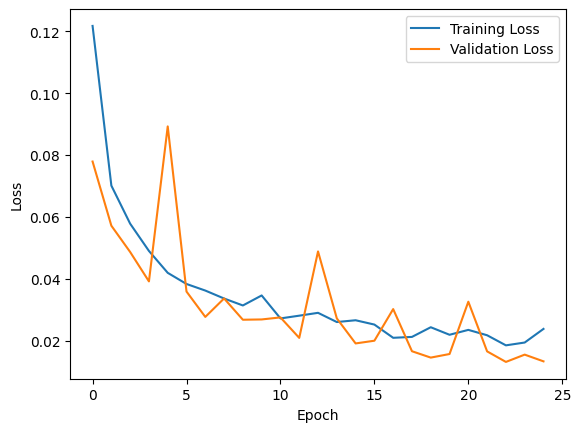

In [ ]:
plot_history(gain_history)

In [ ]:
joblib.dump(gain_GRUmodel, './gainGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./gainGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

### Noise

In [ ]:
noise_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
noise_history = noise_GRUmodel.fit(noiseX_train, noiseY_train,batch_size=20, epochs=25, validation_data=(noiseX_val, noiseY_val))


Model compiled!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 120)            │        46,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           242 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,162 (184.23 KB)

 Trainable params: 46,922 (183.29 KB)

 Non-trainable params: 240 (960.00 B)

None
Epoch 1/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9544 - loss: 0.1447 - val_accuracy: 0.9761 - val_loss: 0.0726
Epoch 2/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9905 - loss: 0.0277 - val_accuracy: 0.9907 - val_loss: 0.0304
Epoch 3/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.9915 - loss: 0.0259 - val_accuracy: 0.9391 - val_loss: 0.2194
Epoch 4/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9929 - loss: 0.0189 - val_accuracy: 0.9197 - val_loss: 0.1970
Epoch 5/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.9926 - loss: 0.0210 - val_accuracy: 0.9732 - val_loss: 0.0825
Epoch 6/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9944 - loss: 0.0160 - val_accuracy: 0.9967 - val_loss: 0.0100
Epoch 7/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9947 - val_loss: 0.0123
Epoch 8/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.9

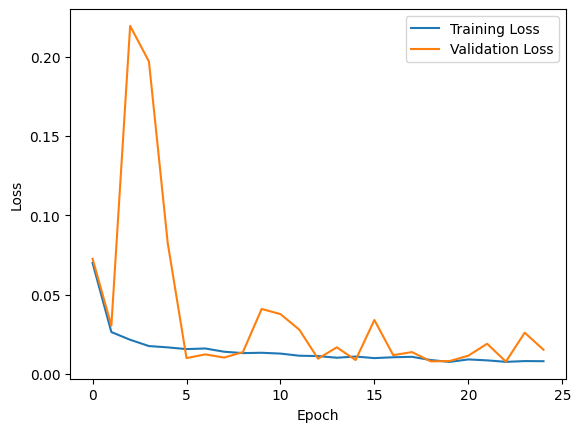

In [ ]:
plot_history(noise_history)

In [ ]:
joblib.dump(noise_GRUmodel, './noiseGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./noiseGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

### Packet Loss

In [ ]:
packetLoss_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
packetLoss_history = packetLoss_GRUmodel.fit(packetLossX_train, packetLossY_train,batch_size=20, epochs=25, validation_data=(packetLossX_val, packetLossY_val))


Model compiled!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 120)            │        46,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           242 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,162 (184.23 KB)

 Trainable params: 46,922 (183.29 KB)

 Non-trainable params: 240 (960.00 B)

None
Epoch 1/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9226 - loss: 0.2038 - val_accuracy: 0.8242 - val_loss: 0.4717
Epoch 2/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.9759 - loss: 0.0654 - val_accuracy: 0.9802 - val_loss: 0.0573
Epoch 3/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9822 - loss: 0.0511 - val_accuracy: 0.9876 - val_loss: 0.0370
Epoch 4/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.9815 - loss: 0.0533 - val_accuracy: 0.9396 - val_loss: 0.1306
Epoch 5/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.9856 - loss: 0.0436 - val_accuracy: 0.9759 - val_loss: 0.0724
Epoch 6/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9884 - loss: 0.0385 - val_accuracy: 0.9912 - val_loss: 0.0275
Epoch 7/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9525 - val_loss: 0.1119
Epoch 8/25
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9

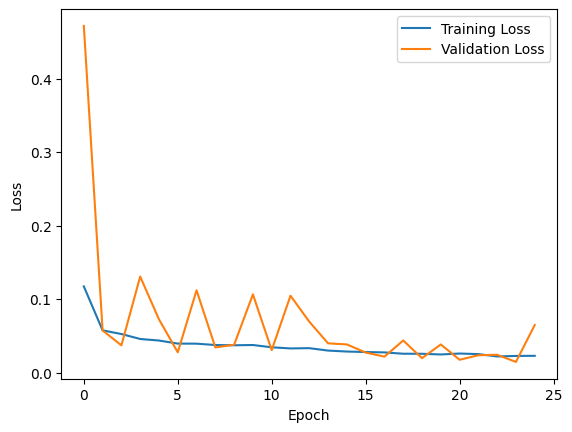

In [ ]:
plot_history(packetLoss_history)

In [ ]:
joblib.dump(packetLoss_GRUmodel, './packetLossGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./packetLossGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

# Evaluation

### Delay

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3769
           1       0.94      0.98      0.96       416

    accuracy                           0.99      4185
   macro avg       0.97      0.99      0.98      4185
weighted avg       0.99      0.99      0.99      4185

Confusion Matrix:


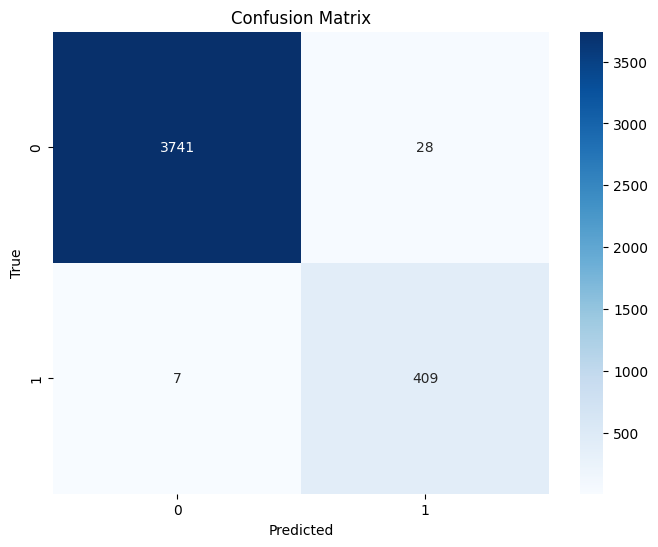

In [ ]:
print("Classification Report:")
pred = delay_GRUmodel.predict(delayX_test,verbose=0)
report = generate_classificationReport(np.argmax(delayY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(delayY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

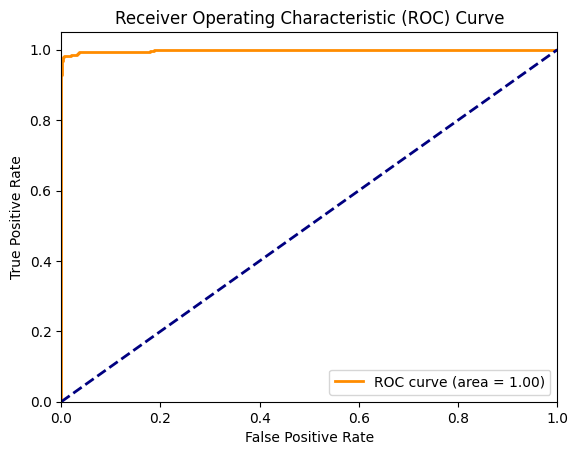

In [ ]:
fpr, tpr, _ = roc_curve(np.argmax(delayY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Gain

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18      3520
           1       0.17      1.00      0.30       665

    accuracy                           0.24      4185
   macro avg       0.59      0.55      0.24      4185
weighted avg       0.87      0.24      0.20      4185

Confusion Matrix:


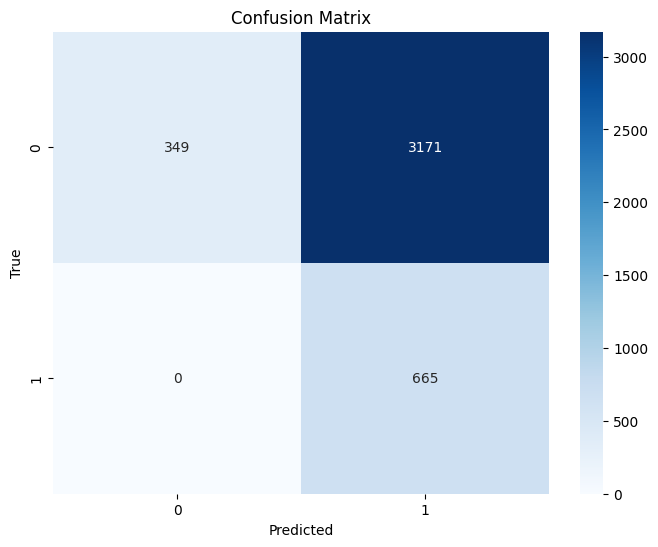

In [ ]:
print("Classification Report:")
pred = gain_GRUmodel.predict(gainX_test,verbose=0)
report = generate_classificationReport(np.argmax(gainY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(gainY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

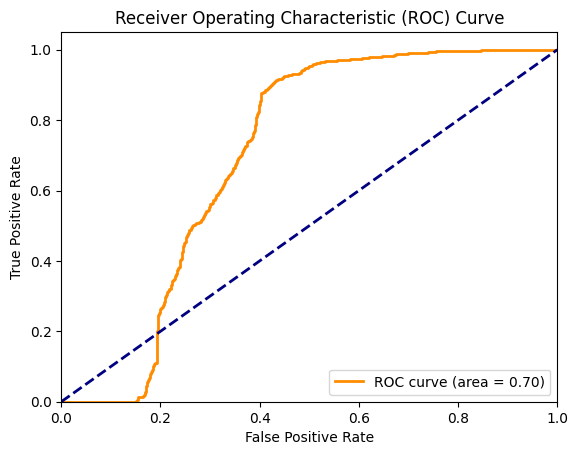

In [ ]:
fpr, tpr, _ = roc_curve(np.argmax(gainY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Noise

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3690
           1       0.99      0.97      0.98       495

    accuracy                           1.00      4185
   macro avg       0.99      0.99      0.99      4185
weighted avg       1.00      1.00      1.00      4185

Confusion Matrix:


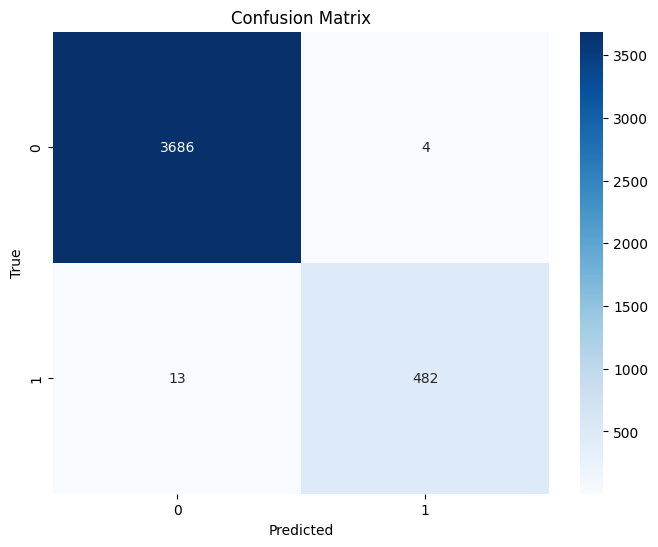

In [ ]:
print("Classification Report:")
pred = noise_GRUmodel.predict(noiseX_test,verbose=0)
# y_true, pred= single_fault_voter(noiseY_test, pred)
report = generate_classificationReport(np.argmax(noiseY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(noiseY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

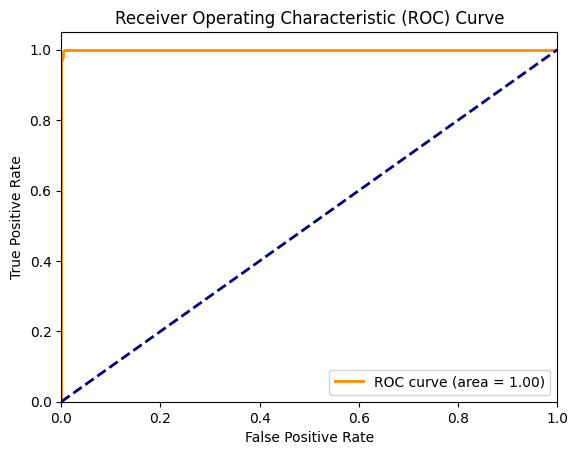

In [ ]:
fpr, tpr, _ = roc_curve(np.argmax(noiseY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Packet Loss

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.10      0.17      3684
           1       0.13      1.00      0.23       501

    accuracy                           0.20      4185
   macro avg       0.56      0.55      0.20      4185
weighted avg       0.89      0.20      0.18      4185

Confusion Matrix:


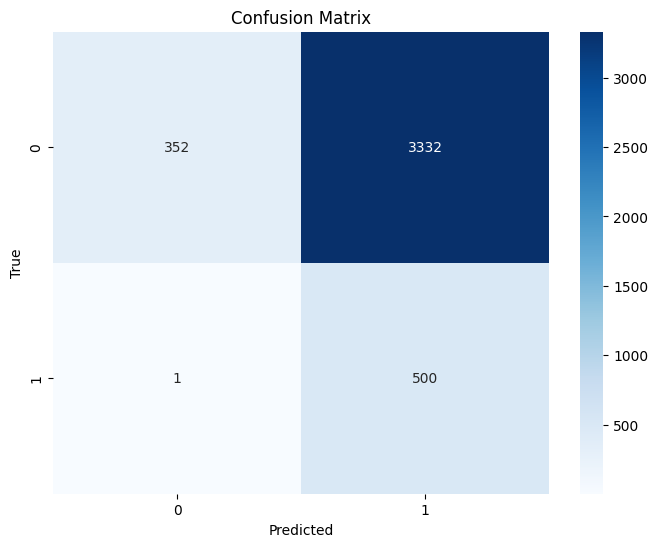

In [ ]:
print("Classification Report:")
pred = packetLoss_GRUmodel.predict(packetLossX_test,verbose=0)
# y_true, pred= single_fault_voter(packetLossY_test, pred)
report = generate_classificationReport(np.argmax(packetLossY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(packetLossY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

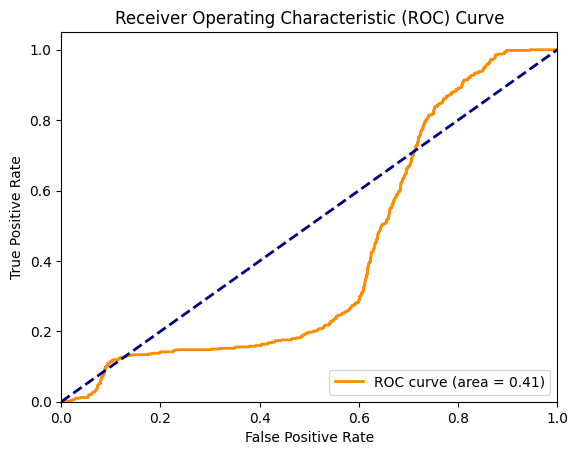

In [ ]:
fpr, tpr, _ = roc_curve(np.argmax(packetLossY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np


def sliding_sequences2(combined_data, window_size=50):
    combined_data = combined_data.copy()
    columns = combined_data.columns.tolist()
    print(f"DataFrame columns: {columns}")

    # Assuming all columns except 'delay_class' are features
    features = [col for col in columns if col != 'delay_class']
    print(f"Identified features: {features}")

    if not features:
        print("No features found. Check your column names.")
        return np.array([])

    X_train_data = combined_data[features]

    scaled_X_df = (X_train_data - X_train_data.min()) / \
        (X_train_data.max() - X_train_data.min())
    combined_data[features] = scaled_X_df

    df = combined_data

    X_train = []

    for i in range(len(df) - window_size + 1):
        temp = df[i: i + window_size]
        sequence_features = temp[features]
        X_train.append(sequence_features.values)

    X_train = np.array(X_train)

    return X_train

# Example usage:
# Assuming combined_data is a single dataframe containing sensor readings and class column 'delay_class'
# combined_data = pd.DataFrame(...)  # replace with actual dataframe

# Uncomment the following line and replace with actual data
# delayX_train = sliding_sequences2(combined_data, window_size=50)

# Print shape
# print(f'delayX_train shape: {delayX_train.shape}')

## CONCURRENT FAULTS DETECTION

In [ ]:
# Importing the models
delay_GRUmodel = joblib.load('./delayGRU_softmax_rebalanced_plus_minmax_sliding.pkl')
gain_GRUmodel = joblib.load('./gainGRU_softmax_relabeled_plus_minmax_sliding.pkl')
noise_GRUmodel = joblib.load('./noiseGRU_softmax_rebalanced_plus_minmax_sliding.pkl')
packetLoss_GRUmodel = joblib.load('./packetLossGRU_softmmax_rebalanced_plus_minmax_sliding.pkl')

In [ ]:
# Importing the testing data
gainRPM_delayAPP = pd.read_csv('./con/GainRPM_DelayAPP.csv').reset_index(drop=True)
gainRPM_noiseAPP = pd.read_csv('./con/GainRPM_NoiseAPP.csv').reset_index(drop=True)
gainRPM_packetlossAPP = pd.read_csv('./con/GainRPM_PacketlossAPP.csv').reset_index(drop=True)

In [ ]:
gainRPM_delayAPPX_test = sliding_sequences2(gainRPM_delayAPP,window_size=100)
gainRPM_noiseAPPX_test = sliding_sequences2(gainRPM_noiseAPP,window_size=100)
gainRPM_packetlossAPPX_test = sliding_sequences2(gainRPM_packetlossAPP,window_size=100)

# New Voter based on model confidence

In [ ]:
def concurrent_voter(data):
    gain_prediction = np.argmax(gain_GRUmodel.predict(data),axis=1)
    gain_confidence = np.max(gain_GRUmodel.predict(data),axis=1)
    noise_prediction = np.argmax(noise_GRUmodel.predict(data),axis=1)
    noise_confidence = np.max(noise_GRUmodel.predict(data),axis=1)
    packetLoss_prediction = np.argmax(packetLoss_GRUmodel.predict(data),axis=1)
    packetLoss_confidence = np.max(packetLoss_GRUmodel.predict(data),axis=1)
    delay_prediction = np.argmax(delay_GRUmodel.predict(data),axis=1)
    delay_confidence = np.max(delay_GRUmodel.predict(data),axis=1)
    # Combine predictions and confidences for each classifier
    predictions = {
        "gain": gain_prediction,
        "noise": noise_prediction,
        "packetLoss": packetLoss_prediction,
        "delay": delay_prediction
    }

    confidences = {
        "gain": gain_confidence,
        "noise": noise_confidence,
        "packetLoss": packetLoss_confidence,
        "delay": delay_confidence
    }

    # Combine predictions and confidences into one array
    combined_predictions = []
    for i in range(len(gain_prediction)):
        label_confidences = {}
        for key, value in confidences.items():
            label_confidences[key] = (predictions[key][i], value[i])
        combined_predictions.append(label_confidences)

    # Select label with the highest confidence for each data point
    final_predictions = []
    for pred in combined_predictions:
        top_faults = sorted(pred, key=lambda x: pred[x][1], reverse=True)[:2]
        final_predictions.append(top_faults)

    # Convert final predictions to array
    final_predictions = np.array(final_predictions)

    return final_predictions

### TESTS USING NEW DATA

#### Gain and Delay (F2 and F1)

In [ ]:
gain_delay = concurrent_voter(gainRPM_delayAPPX_test)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [ ]:
(pd.DataFrame(gain_delay).iloc[:,0].value_counts().index[0],pd.DataFrame(gain_delay).iloc[:,1].value_counts().index[0])

('noise', 'delay')

#### Gain and Noise (F2 and F3)

In [ ]:
gain_noise = concurrent_voter(gainRPM_noiseAPPX_test)


249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [ ]:
(pd.DataFrame(gain_noise).iloc[:,0].value_counts().index[0],pd.DataFrame(gain_noise).iloc[:,1].value_counts().index[0])

('noise', 'packetLoss')

#### Gain and Packet Loss (F2 and F4)

In [ ]:
gain_packetloss = concurrent_voter(gainRPM_packetlossAPPX_test)

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
(pd.DataFrame(gain_packetloss).iloc[:,0].value_counts().index[0],pd.DataFrame(gain_packetloss).iloc[:,1].value_counts().index[0])

('noise', 'noise')